# Brazilian rent price: Data analysis

## Motivation
This notebook is going to be focused on solving the problem of predicting house rent in five cities of Brazil.

A house value is simply more than location and square footage. We are going to take advantage of all of the feature variables available to use and use it to analyze and predict house rent prices.

We are going to break everything into logical steps that allow us to ensure the cleanest, most realistic data for our model to make accurate predictions from.

## Understanding the Client and their Problem

A benefit to this study is that we can have two clients at the same time! (Think of being a divorce lawyer for both interested parties) However, in this case, we can have both clients with no conflict of interest!

Client Housebuyer: This client wants to find their next dream home with a reasonable price tag. They have their locations of interest ready. Now, they want to know if the house price matches the house value. With this study, they can understand which features (ex. Number of bathrooms, location, etc.) influence the final price of the house. If all matches, they can ensure that they are getting a fair price.

Client Houseseller: Think of the average house-flipper. This client wants to take advantage of the features that influence a house price the most. They typically want to buy a house at a low price and invest on the features that will give the highest return. For example, buying a house at a good location but small square footage. The client will invest on making rooms at a small cost to get a large return.
Data

Our data comes from a Kaggle competition named “brazilian_houses_to_rent”, which is a dataset houses to rent in diferents cities in Brazil.
It contains 10962 training data points and 13 features that might help us predict the selling price of a house.

## Loading Data and Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/brasilian-houses-to-rent/houses_to_rent_v2.csv
/kaggle/input/brasilian-houses-to-rent/houses_to_rent.csv


In [2]:
filename1 = "/kaggle/input/brasilian-houses-to-rent/houses_to_rent.csv"
filename2 = "/kaggle/input/brasilian-houses-to-rent/houses_to_rent_v2.csv"

In [3]:
df = pd.read_csv(filename2)

# take a look at the dataset
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


## Unique cities

In [4]:
cities = df['city'].unique()
cities

array(['São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas',
       'Belo Horizonte'], dtype=object)

## Prices

In [6]:
df['total (R$)'].describe().apply(lambda x: format(x, 'f'))

count      10692.000000
mean        5490.487000
std        16484.725912
min          499.000000
25%         2061.750000
50%         3581.500000
75%         6768.000000
max      1120000.000000
Name: total (R$), dtype: object

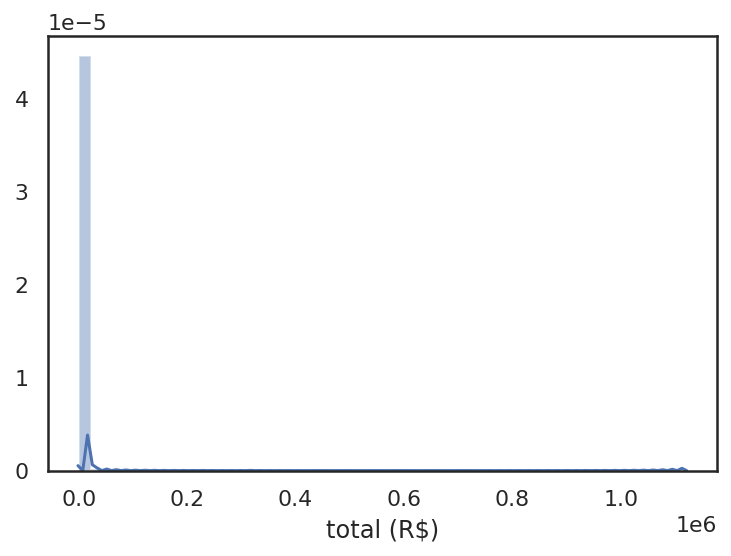

In [7]:
sns.distplot(df['total (R$)']);

It seems a very strange price distribuiton. Existe preços muito altos, prém são preços 'fora da curva'. Vamos identifica-los

In [8]:
big_price = df[df['total (R$)'] > 50000]
big_price

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
255,Belo Horizonte,155,1,4,0,4,not acept,not furnished,1117000,2790,64,38,1120000
2182,São Paulo,700,4,7,8,-,acept,not furnished,0,45000,8750,677,54430
2859,São Paulo,285,4,5,4,6,acept,furnished,200000,20000,1834,254,222100
2928,Rio de Janeiro,35,1,1,0,1,acept,furnished,81150,4500,9900,58,95610
6230,São Paulo,340,5,4,2,7,acept,not furnished,220000,12000,1000,153,233200
6645,São Paulo,42,1,2,1,6,not acept,not furnished,690,2500,313700,32,316900
6979,Belo Horizonte,155,1,4,0,4,not acept,not furnished,1117000,2790,64,38,1120000


Vemos que são apenas 7 casa. Além disso, 255 e 6979 parecem ser o mesmo dado. Vamos retirar esses 7 dados da tabela

In [9]:
df_clean = df.drop(big_price.index)

In [10]:
df_clean['total (R$)'].describe()

count    10685.000000
mean      5198.132616
std       4473.376271
min        499.000000
25%       2061.000000
50%       3578.000000
75%       6758.000000
max      32750.000000
Name: total (R$), dtype: float64

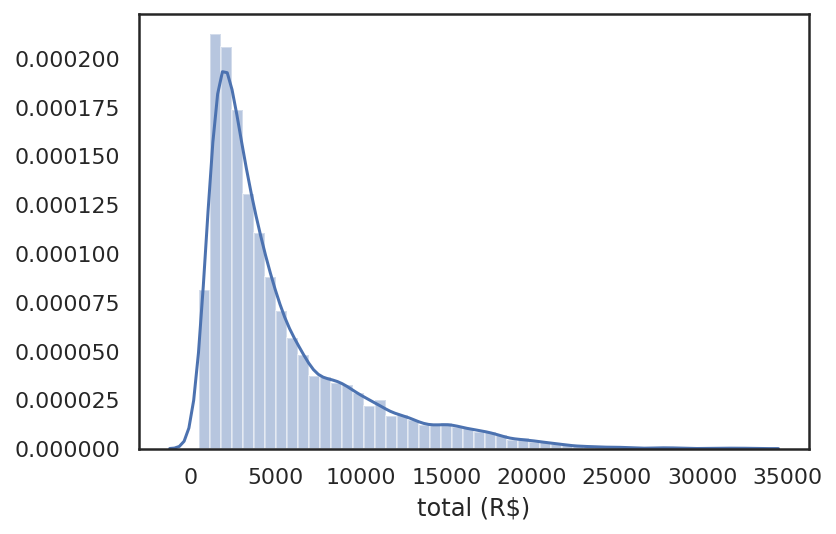

In [11]:
sns.distplot(df_clean['total (R$)']);


 mu = 5198.13 and sigma = 4473.17



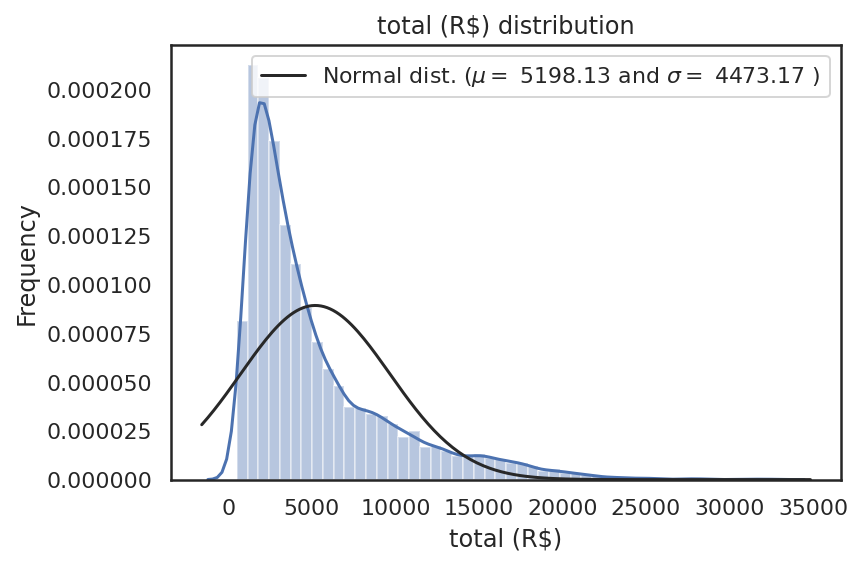

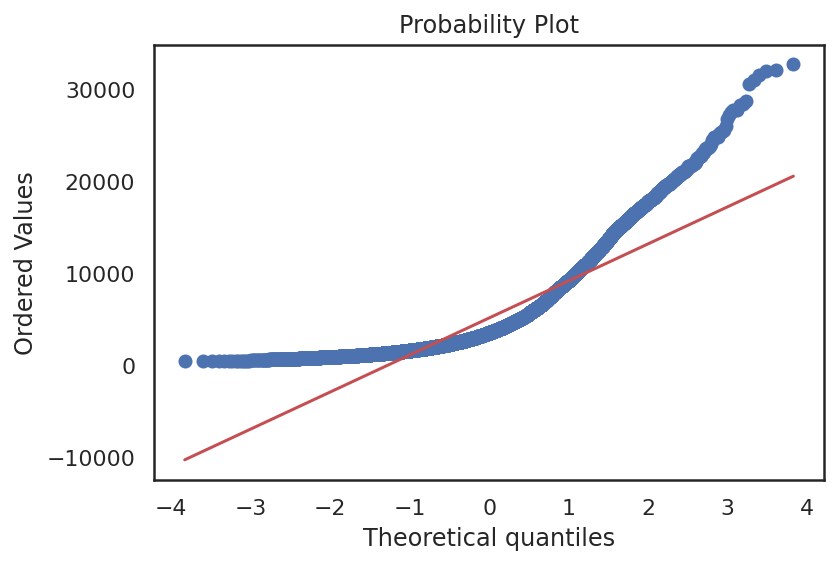

Skewness: 1.736604
Kurtosis: 3.208330


In [13]:
sns.distplot(df_clean['total (R$)'], fit=norm);

(mu, sigma) = norm.fit(df_clean['total (R$)'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('total (R$) distribution')

fig = plt.figure()
res = stats.probplot(df_clean['total (R$)'], plot=plt)
plt.show()

print("Skewness: %f" % df_clean['total (R$)'].skew())
print("Kurtosis: %f" % df_clean['total (R$)'].kurt())

Looks like a normal distribution? Not quite! Looking at the kurtosis score, we can see that there is a very nice peak. However, looking at the skewness score, we can see that the sale prices deviate from the normal distribution. Going to have to fix this later! We want our data to be as "normal" as possible.

In [ ]:
# Create a figure and axes. Then plot the data
fig, ax = plt.subplots()
sns.distplot(df['fmr_1'], ax=ax)

# Customize the labels and limits
ax.set(xlabel="1 Bedroom Fair Market Rent", xlim=(100,1500), title="US Rent")

# Add vertical lines for the median and mean
ax.axvline(x=median, color='m', label='Median', linestyle='--', linewidth=2) #shows the median)
ax.axvline(x=mean, color='b', label='Mean', linestyle='-', linewidth=2) #shows the mean

# Show the legend and plot the data
ax.legend()
plt.show()

## Missing data

In [ ]:
total = df_clean_v3.isnull().sum().sort_values(ascending=False)
percent = (df_clean_v3.isnull().sum()/df_clean_v3.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

No missing data! But is it true?

In [ ]:
df['floor'].value_counts()

We have 2461 a strange value '-'

In [ ]:
df_floor = df[df['floor'] == '-']
df_floor['total (R$)'].describe()

In [ ]:
sns.distplot(df_floor['total (R$)']);

## Kind of Data

In [ ]:
df_clean.select_dtypes(include=['object']).columns

In [ ]:
df_clean.select_dtypes(include=['int64','float64']).columns

# Variables 

### Area vs Price

In [ ]:
sns.relplot(x = 'area',y='total (R$)',data=df_clean,kind='scatter',size='total (R$)')

Again, here we have some problems, there are some strange data. Let's find and drop them.

In [ ]:
df_clean_v2 = df_clean.drop(big_area.index)

In [ ]:
sns.relplot(x = 'area',y='total (R$)',data=df_clean_v2,kind='scatter',size='total (R$)')

You might’ve expected that larger living area should mean a higher price.

### City vs Price

In [ ]:
var = 'city'
data = pd.concat([df_clean_v3['total (R$)'], df_clean_v3[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v3)
fig.axis(ymin=0, ymax=35000);

Claramente, São paulo tem uma média de preço maior que as outras cidade

### Rooms vs Price

In [ ]:
var = 'rooms'
data = pd.concat([df_clean_v3['total (R$)'], df_clean_v3[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v3)
fig.axis(ymin=0, ymax=35000);

### Animal vs Price

In [ ]:
plt.figure()
sns.countplot(x='city', hue='animal', data=df, palette='RdBu')
plt.xticks([0,1,2,3,4], cities)
plt.show()
#gostara de fazer um gráfico barra de cada cidade escrevendo numero de aceitações e nã aceitações

In [ ]:
var = 'animal'
data = pd.concat([df_clean_v3['total (R$)'], df_clean_v3[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v3)
fig.axis(ymin=0, ymax=35000);

### Furniture vs Price

In [ ]:
plt.figure()
sns.countplot(x='city', hue='furniture', data=df, palette='RdBu')
plt.xticks([0,1,2,3,4], cities)
plt.show()

In [ ]:
var = 'furniture'
data = pd.concat([df_clean_v3['total (R$)'], df_clean_v3[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v3)
fig.axis(ymin=0, ymax=35000);

### Bathrooms vs Price

In [ ]:
var = 'bathroom'
data = pd.concat([df_clean_v3['total (R$)'], df_clean_v3[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v3)
fig.axis(ymin=0, ymax=35000);

### Parking spaces vs Price

In [ ]:
var = 'parking spaces'
data = pd.concat([df_clean_v3['total (R$)'], df_clean_v3[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v3)
fig.axis(ymin=0, ymax=35000);

### Summary

In [ ]:
cols = ['total (R$)', 'rooms', 'bathroom', 'area']
sns.pairplot(df_clean_v3[cols], size = 4);

### Correlation matrix

In [ ]:
corrmat = df_clean_v3.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# São Paulo

In [ ]:
df_sp = df_clean_v2[df_clean_v2['city'] == 'São Paulo']
df_sp.head(5)

# Belo Horizonte

In [ ]:
df_bh = df_clean_v2[df_clean_v2['city'] == 'Belo Horizonte']
df_bh.head(5)

# Porto Alegre

In [ ]:
df_poa = df_clean_v2[df_clean_v2['city'] == 'Porto Alegre']
df_poa.head(5)

# Campinas

In [ ]:
df_camp = df_clean_v2[df_clean_v2['city'] == 'Campinas']
df_camp.head(5)

# Rio de Janeiro

In [ ]:
df_rj = df_clean_v2[df_clean_v2['city'] == 'Rio de Janeiro']
df_rj.head(5)

# Machine Learning

In [ ]:
df_clean_v3["total (R$)"] = np.log1p(df_clean_v3["total (R$)"])

sns.distplot(df_clean_v3["total (R$)"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_clean_v3["total (R$)"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_clean_v3["total (R$)"], plot=plt)
plt.show()

y_train = df_clean_v3['total (R$)'].values

print("Skewness: %f" % df_clean_v3["total (R$)"].skew())
print("Kurtosis: %f" % df_clean_v3["total (R$)"].kurt())

In [ ]:
x = df_clean_v3['area']
y = df_clean_v3['total (R$)']

x = (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x] 

In [ ]:
x.shape

In [ ]:
def loss(h, y):
  sq_error = (h - y)**2
  n = len(y)
  return 1.0 / (2*n) * sq_error.sum()

In [ ]:
import unittest

class TestLoss(unittest.TestCase):

  def test_zero_h_zero_y(self):
    self.assertAlmostEqual(loss(h=np.array([0]), y=np.array([0])), 0)

  def test_one_h_zero_y(self):
    self.assertAlmostEqual(loss(h=np.array([1]), y=np.array([0])), 0.5)

  def test_two_h_zero_y(self):
    self.assertAlmostEqual(loss(h=np.array([2]), y=np.array([0])), 2)
    
  def test_zero_h_one_y(self):
    self.assertAlmostEqual(loss(h=np.array([0]), y=np.array([1])), 0.5)
    
  def test_zero_h_two_y(self):
    self.assertAlmostEqual(loss(h=np.array([0]), y=np.array([2])), 2)

In [ ]:
def run_tests():
  unittest.main(argv=[''], verbosity=1, exit=False)

run_tests()

In [ ]:
class LinearRegression:
  
  def predict(self, X):
    return np.dot(X, self._W)
  
  def _gradient_descent_step(self, X, targets, lr):

    predictions = self.predict(X)
    
    error = predictions - targets
    gradient = np.dot(X.T,  error) / len(X)

    self._W -= lr * gradient
      
  def fit(self, X, y, n_iter=100000, lr=0.01):

    self._W = np.zeros(X.shape[1])

    self._cost_history = []
    self._w_history = [self._W]
    for i in range(n_iter):
      
        prediction = self.predict(X)
        cost = loss(prediction, y)
        
        self._cost_history.append(cost)
        
        self._gradient_descent_step(x, y, lr)
        
        self._w_history.append(self._W.copy())
    return self

In [ ]:
class TestLinearRegression(unittest.TestCase):

    def test_find_coefficients(self):
      clf = LinearRegression()
      clf.fit(x, y, n_iter=2000, lr=0.01)
      np.testing.assert_array_almost_equal(clf._W, np.array([180921.19555322,  56294.90199925]))

In [ ]:
run_tests()

In [ ]:
clf = LinearRegression()
clf.fit(x, y, n_iter=2000, lr=0.01)

In [ ]:
clf._W

In [ ]:
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(clf._cost_history)
plt.show()

In [ ]:
x = df_clean_v3[['rooms', 'bathroom', 'area']]

x = (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x] 

In [ ]:
clf = LinearRegression()
clf.fit(x, y, n_iter=2000, lr=0.01)

In [ ]:
clf._W

In [ ]:
#check for null values
df.isnull().sum()

In [ ]:
#check correlation
df.corr().style.background_gradient(cmap = 'coolwarm')

As you can see above, apart from the (R$) values the features that make the most impact are rooms, bathrooms and parking spaces.

To further check the correlation of the features and the features that are most important to determine the Total, let us take the approach of Backward Elimination Algorithm by using the Ordinary Least Square method to find the summary of the dataset.

Lets select some features to explore more.

In [ ]:
cdf = df[['area','rooms','bathroom','parking spaces','total (R$)']]
cdf.head(9)

we can plot each of these features:

In [ ]:
viz = cdf[['rooms','bathroom','parking spaces']]
viz.hist()
plt.show()

Now, lets plot each of these features vs price, to see how linear is their relation:

In [ ]:
cdf['totalprice'] = cdf['total (R$)']

In [ ]:
cdf.head()

In [ ]:
plt.scatter(cdf.rooms, cdf.totalprice,  color='blue')
plt.xlabel("Number of rooms")
plt.ylabel("Total Price")
plt.show()

In [ ]:
plt.scatter(cdf.bathroom, cdf.totalprice,  color='blue')
plt.xlabel("Number of Bathrooms")
plt.ylabel("Total Price")
plt.show()

In [ ]:
plt.scatter(cdf['parking spaces'], cdf.totalprice,  color='blue')
plt.xlabel("Number of Bathrooms")
plt.ylabel("Total Price")
plt.show()

## Creating train and test dataset

Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the data. It is more realistic for real world problems.

This means that we know the outcome of each data point in this dataset, making it great to test with! And since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

In [ ]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

In [ ]:
plt.scatter(train.rooms, train.totalprice,  color='blue')
plt.xlabel("Rooms")
plt.ylabel("Price")
plt.show()

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['rooms']])
train_y = np.asanyarray(train[['totalprice']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

In [ ]:
plt.scatter(train.rooms, train.totalprice,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Rooms")
plt.ylabel("Price")

In [ ]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['rooms']])
test_y = np.asanyarray(test[['totalprice']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_ , test_y) )

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['rooms','bathroom','parking spaces']])
y = np.asanyarray(train[['totalprice']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

As mentioned before, __Coefficient__ and __Intercept__ , are the parameters of the fit line. 
Given that it is a multiple linear regression, with 3 parameters, and knowing that the parameters are the intercept and coefficients of hyperplane, sklearn can estimate them from our data. Scikit-learn uses plain Ordinary Least Squares method to solve this problem.

#### Ordinary Least Squares (OLS)
OLS is a method for estimating the unknown parameters in a linear regression model. OLS chooses the parameters of a linear function of a set of explanatory variables by minimizing the sum of the squares of the differences between the target dependent variable and those predicted by the linear function. In other words, it tries to minimizes the sum of squared errors (SSE) or mean squared error (MSE) between the target variable (y) and our predicted output ($\hat{y}$) over all samples in the dataset.

OLS can find the best parameters using of the following methods:
    - Solving the model parameters analytically using closed-form equations
    - Using an optimization algorithm (Gradient Descent, Stochastic Gradient Descent, Newton’s Method, etc.)

<h2 id="prediction">Prediction</h2>

In [ ]:
y_hat= regr.predict(test[['rooms','bathroom','parking spaces']])
x = np.asanyarray(test[['rooms','bathroom','parking spaces']])
y = np.asanyarray(test[['totalprice']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

In [ ]:
import statsmodels.formula.api as smf

# Add a new column with educ squared
gss['educ2'] = gss['educ']**2

# Run a regression model with educ, educ2, age, and age2
results = smf.ols('realinc ~ educ + educ2 + age + age2',data = gss).fit()

# Print the estimated parameters
print(results.params)

In [ ]:
# Run a regression model with educ, educ2, age, and age2
results = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss).fit()

# Make the DataFrame
df = pd.DataFrame()
df['educ'] = np.linspace(0,20)
df['age'] = 30
df['educ2'] = df['educ']**2
df['age2'] = df['age']**2

# Generate and plot the predictions
pred = results.predict(df)
print(pred.head())

In [ ]:
# Plot mean income in each age group
plt.clf()
grouped = gss.groupby('educ')
mean_income_by_educ = grouped['realinc'].mean()
plt.plot(mean_income_by_educ,'o',alpha=0.5)

# Plot the predictions
pred = results.predict(df)
plt.plot(df['educ'], pred, label='Age 30')

# Label axes
plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.legend()
plt.show()


In [ ]:
# Adjust to add subgroups based on "Interested in Pets"
g = sns.catplot(x="Gender",
                y="Age", data=survey_data, 
                kind="box", hue='Interested in Pets')